### Focus: The "Kitchen Sink" (Aggressive).

### 1.Setup & Data Loading

In [39]:
import pandas as pd
import numpy as np
import os

# 1. CONFIGURATION
# choosing 16 as it had the most well balanced dataset
INPUT_FILENAME = "triple_barrier_16h.parquet" 
INPUT_PATH = os.path.join('../data', INPUT_FILENAME)
OUTPUT_FILENAME = "engineered_features_16h.parquet"
OUTPUT_PATH = os.path.join('../data', OUTPUT_FILENAME)

# 2. LOAD DATA
print(f"Loading data from {INPUT_PATH}...")
df = pd.read_parquet(INPUT_PATH)

# Ensure index is datetime
if not isinstance(df.index, pd.DatetimeIndex):
    # if not then simply convert it
    df.index = pd.to_datetime(df.index)

print(f"Initial Shape: {df.shape}")
print("Data loaded successfully.")

Loading data from ../data\triple_barrier_16h.parquet...
Initial Shape: (9301, 12)
Data loaded successfully.


In [40]:
df.shape

(9301, 12)

### 2: Time Standardization (UTC+2 -> UTC)

In [36]:
# 1. STANDARDIZE TIMEZONE
# Data is UTC+2 (Broker Time). We subtract 2 hours to get true UTC.
print("Shifting time from UTC+2 to UTC...")

# this is a fancy operation to remove 2 hours and hence convert the timeframt to utc
df.index = df.index - pd.Timedelta(hours=2)

# Verify the shift (Optional check)
# If it was 10:00 Broker time, it should now be 08:00 UTC (London Open)
print(f"New start time (UTC): {df.index[0]}")
print(f"New end time (UTC): {df.index[-1]}")

Shifting time from UTC+2 to UTC...
New start time (UTC): 2020-01-06 06:00:00
New end time (UTC): 2025-12-24 02:00:00


### 3. Aggressive Technical & Statistical Features

In [11]:
# # Create a copy to work on like a nroaml person
# df_feat = df.copy()

# print("Generating features...")

# # ==========================================
# # 1. TIME & SESSION CONTEXT
# # ==========================================
# # Cyclical Time (Clock Coordinates)


# # We use Sine and Cosine to map the hours onto a circle. Now,
# # 11 PM and Midnight are mathematically close to each other

# df_feat['hour_sin'] = np.sin(2 * np.pi * df_feat.index.hour / 24)
# df_feat['hour_cos'] = np.cos(2 * np.pi * df_feat.index.hour / 24)
# df_feat['day_sin'] = np.sin(2 * np.pi * df_feat.index.dayofweek / 7)
# df_feat['day_cos'] = np.cos(2 * np.pi * df_feat.index.dayofweek / 7)

# # Session Booleans (Based on UTC)
# h = df_feat.index.hour
# df_feat['sess_london'] = ((h >= 7) & (h <= 16)).astype(int)
# df_feat['sess_ny'] = ((h >= 12) & (h <= 21)).astype(int)
# df_feat['sess_tokyo'] = ((h >= 0) & (h <= 9)).astype(int)
# df_feat['sess_sydney'] = ((h >= 21) | (h <= 6)).astype(int) # Wraps midnight

# # Critical Overlaps & Zones
# df_feat['sess_london_ny'] = (df_feat['sess_london'] & df_feat['sess_ny']).astype(int)
# df_feat['sess_tokyo_london'] = (df_feat['sess_tokyo'] & df_feat['sess_london']).astype(int)

# # The US banks are closed, and Tokyo hasn't opened fully. Spreads widen, and moves are often fake.
# df_feat['sess_dead_zone'] = ((h >= 21) | (h == 0)).astype(int) # Late NY / Early Syd

# # The market literally goes to lunch. Volume drops to zero.
# df_feat['sess_asian_lunch'] = ((h >= 3) & (h <= 4)).astype(int) # Low Volatility

# # ==========================================
# # 2. MARKET MICROSTRUCTURE (Spread & Vol)
# # ==========================================
# # Spread Features (Liquidity Risk)
# if 'spread' in df_feat.columns:
#     # Normalize spread by price (e.g., 0.0001 / 1.1000)
#     df_feat['spread_pct'] = df_feat['spread'] / df_feat['close']
#     # Spread Shock: Is spread currently 2x or 3x the average? (News Event Detector)
#     df_feat['spread_shock'] = df_feat['spread'] / df_feat['spread'].rolling(20).mean()
#     print("Spread features added.")


# # Volume Features (Activity)
# vol_col = 'tick_volume' if 'tick_volume' in df_feat.columns else 'volume' if 'volume' in df_feat.columns else None

# if vol_col:

#     # Price moves up + Low Volume: The car is coasting uphill. It will likely roll back (False Breakout).
#     df_feat['vol_rel'] = df_feat[vol_col] / df_feat[vol_col].rolling(20).mean()
    
#     # Force volume stationarity (Rate of Change)
#     df_feat['vol_roc'] = df_feat[vol_col].pct_change()
#     print(f"Volume features added using column: {vol_col}")

# # ==========================================
# # 3. VOLATILITY & STATS
# # ==========================================
# # Bollinger Bands
# sma_20 = df_feat['close'].rolling(20).mean()
# std_20 = df_feat['close'].rolling(20).std()
# bb_upper = sma_20 + (std_20 * 2)
# bb_lower = sma_20 - (std_20 * 2)

# # o measure if the market is "nervous" (volatile) or "calm", 
# # and if price is "stretched" (likely to snap back).
# df_feat['bb_width'] = (bb_upper - bb_lower) / sma_20 # Squeeze/Expand
# df_feat['bb_pos'] = (df_feat['close'] - bb_lower) / (bb_upper - bb_lower) # Position



# # Rolling Distribution Shape (The "Aggressive" Stats)
# # Intuition (The Shape of Danger):

# for window in [20, 50]:
#     # Is the market crashing up or crashing down?
#     df_feat[f'roll_skew_{window}'] = df_feat['close'].rolling(window).skew()
#     # High kurtosis means the market is jumpy and dangerous.
#     df_feat[f'roll_kurt_{window}'] = df_feat['close'].rolling(window).kurt()

# # ATR % (if ATR exists from labelling)
# if 'atr' in df_feat.columns:
#     df_feat['atr_pct'] = df_feat['atr'] / df_feat['close']

# # ==========================================
# # 4. MOMENTUM & TREND (Stationary)
# # ==========================================
# # RSI
# # Intuition (The Speedometer): How fast is price changing? If RSI > 70, the engine is redlining.

# for window in [7, 14, 21]:
#     delta = df_feat['close'].diff()
#     gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
#     loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
#     rs = gain / loss
#     df_feat[f'rsi_{window}'] = 100 - (100 / (1 + rs))

# # MACD
# ema_12 = df_feat['close'].ewm(span=12, adjust=False).mean()
# ema_26 = df_feat['close'].ewm(span=26, adjust=False).mean()

# # "Are the short-term and long-term trends agreeing or fighting?"
# df_feat['macd_hist'] = (ema_12 - ema_26) - (ema_12 - ema_26).ewm(span=9, adjust=False).mean()

# # Distance from Moving Averages (Trend Strength)
# for period in [20, 50, 100, 200]:
#     ma = df_feat['close'].rolling(period).mean()
#     df_feat[f'dist_sma_{period}'] = (df_feat['close'] - ma) / ma
#     df_feat[f'slope_sma_{period}'] = ma.diff()

# # ==========================================
# # 5. LAGS (Memory)
# # ==========================================
# # Log returns of previous candles
# for lag in [1, 2, 3, 5, 8, 13]:
#     df_feat[f'log_ret_lag_{lag}'] = np.log(df_feat['close'] / df_feat['close'].shift(lag))

# # Cleanup
# # Drop rows with NaN (Warmup period for 200 SMA)
# original_len = len(df_feat)
# df_feat.dropna(inplace=True)

# print("Feature Engineering Complete.")
# print(f"Dropped {original_len - len(df_feat)} rows (warmup).")
# print(f"Final Feature Count: {df_feat.shape[1]}")

Generating features...
Spread features added.
Volume features added using column: tick_volume
Feature Engineering Complete.
Dropped 200 rows (warmup).
Final Feature Count: 53


### Save Final Dataset

In [12]:
# 1. Save to Parquet
print(f"Saving processed data to {OUTPUT_PATH}...")
df_feat.to_parquet(OUTPUT_PATH, index=True)

# 2. Sanity Check: Inspect the Columns
print("\n--- Feature List ---")
print(df_feat.columns.tolist())

print("\n--- Sample Data (Last 5 rows) ---")
df_feat.tail()

Saving processed data to ../data\engineered_features_16h.parquet...

--- Feature List ---
['open', 'high', 'low', 'close', 'tick_volume', 'spread', 'h-l', 'h-pc', 'l-pc', 'tr', 'atr', 'label', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'sess_london', 'sess_ny', 'sess_tokyo', 'sess_sydney', 'sess_london_ny', 'sess_tokyo_london', 'sess_dead_zone', 'sess_asian_lunch', 'spread_pct', 'spread_shock', 'vol_rel', 'vol_roc', 'bb_width', 'bb_pos', 'roll_skew_20', 'roll_kurt_20', 'roll_skew_50', 'roll_kurt_50', 'atr_pct', 'rsi_7', 'rsi_14', 'rsi_21', 'macd_hist', 'dist_sma_20', 'slope_sma_20', 'dist_sma_50', 'slope_sma_50', 'dist_sma_100', 'slope_sma_100', 'dist_sma_200', 'slope_sma_200', 'log_ret_lag_1', 'log_ret_lag_2', 'log_ret_lag_3', 'log_ret_lag_5', 'log_ret_lag_8', 'log_ret_lag_13']

--- Sample Data (Last 5 rows) ---


,open,high,low,close,tick_volume,spread,h-l,h-pc,l-pc,tr,...,dist_sma_100,slope_sma_100,dist_sma_200,slope_sma_200,log_ret_lag_1,log_ret_lag_2,log_ret_lag_3,log_ret_lag_5,log_ret_lag_8,log_ret_lag_13
time,,,,,,,,,,,,,,,,,,,,,
2025-12-23 10:00:00,1.17925,1.18018,1.17741,1.17746,9584,8.00,0.00277,0.00093,0.00184,0.00277,...,0.007084,0.000178,0.012351,0.000132,-0.001519,-0.000025,0.000144,0.001402,0.004878,0.005322
2025-12-23 14:00:00,1.17747,1.17803,1.17639,1.17707,12337,8.00,0.00164,0.00057,0.00107,0.00164,...,0.006607,0.000166,0.011904,0.000129,-0.000331,-0.001850,-0.000357,0.000841,0.003472,0.004376
2025-12-23 18:00:00,1.17707,1.17968,1.17695,1.17933,4971,8.00,0.00273,0.00261,0.00012,0.00273,...,0.008372,0.000196,0.013735,0.000129,0.001918,0.001587,0.000068,0.001731,0.003636,0.006303
2025-12-23 22:00:00,1.17897,1.18063,1.17894,1.18051,4260,12.75,0.00169,0.00130,0.00039,0.00169,...,0.009223,0.000183,0.014634,0.000132,0.001000,0.002918,0.002587,0.002561,0.003989,0.008174
2025-12-24 02:00:00,1.18053,1.18079,1.17857,1.17990,4235,8.00,0.00222,0.00028,0.00194,0.00222,...,0.008568,0.000154,0.013999,0.000126,-0.000517,0.000483,0.002401,0.000551,0.003243,0.006948


### to be tried later

In [37]:
# !pip install --upgrade numpy

### TRYING OUT THE NEW FEATURES

In [41]:
import pandas as pd
import numpy as np

# ==========================================
# 1. HELPER FUNCTIONS (UNCHANGED)
# ==========================================
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).ewm(alpha=1/period, adjust=False).mean()
    loss = (-delta.where(delta < 0, 0)).ewm(alpha=1/period, adjust=False).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def calculate_atr(df, period=14):
    high_low = df['high'] - df['low']
    high_close = np.abs(df['high'] - df['close'].shift())
    low_close = np.abs(df['low'] - df['close'].shift())
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    return tr.ewm(alpha=1/period, adjust=False).mean()

def calculate_adx(df, period=14):
    tr = calculate_atr(df, period=1)
    up_move = df['high'] - df['high'].shift()
    down_move = df['low'].shift() - df['low']
    plus_dm = np.where((up_move > down_move) & (up_move > 0), up_move, 0)
    minus_dm = np.where((down_move > up_move) & (down_move > 0), down_move, 0)
    
    tr_smooth = pd.Series(tr).ewm(alpha=1/period, adjust=False).mean()
    # SAFETY: Avoid divide by zero if TR is 0
    tr_smooth = tr_smooth.replace(0, np.nan) 
    
    plus_di = 100 * (pd.Series(plus_dm).ewm(alpha=1/period, adjust=False).mean() / tr_smooth)
    minus_di = 100 * (pd.Series(minus_dm).ewm(alpha=1/period, adjust=False).mean() / tr_smooth)
    
    dx = 100 * np.abs(plus_di - minus_di) / (plus_di + minus_di)
    adx = dx.ewm(alpha=1/period, adjust=False).mean()
    return adx

def calculate_psar(df, af_start=0.02, af_inc=0.02, af_max=0.2):
    high = df['high'].values
    low = df['low'].values
    close = df['close'].values
    psar = np.zeros(len(df))
    trend = 1 if close[0] > close[1] else -1 
    af = af_start
    ep = high[0] if trend == 1 else low[0]
    psar[0] = low[0] if trend == 1 else high[0]
    
    for i in range(1, len(df)):
        prev_psar = psar[i-1]
        psar[i] = prev_psar + af * (ep - prev_psar)
        
        if trend == 1:
            psar[i] = min(psar[i], low[i-1])
            if i > 1: psar[i] = min(psar[i], low[i-2])
        else:
            psar[i] = max(psar[i], high[i-1])
            if i > 1: psar[i] = max(psar[i], high[i-2])
            
        reverse = False
        if trend == 1 and low[i] < psar[i]:
            trend = -1
            psar[i] = ep
            ep = low[i]
            af = af_start
            reverse = True
        elif trend == -1 and high[i] > psar[i]:
            trend = 1
            psar[i] = ep
            ep = high[i]
            af = af_start
            reverse = True
        if not reverse:
            if trend == 1:
                if high[i] > ep:
                    ep = high[i]
                    af = min(af + af_inc, af_max)
            else:
                if low[i] < ep:
                    ep = low[i]
                    af = min(af + af_inc, af_max)
    return pd.Series(psar, index=df.index)

def calculate_aroon(df, period=25):
    aroon_up = df['high'].rolling(period + 1).apply(lambda x: x.argmax(), raw=True) / period * 100
    aroon_down = df['low'].rolling(period + 1).apply(lambda x: x.argmin(), raw=True) / period * 100
    return aroon_up, aroon_down

# ==========================================
# 2. DIAGNOSTIC EXECUTION
# ==========================================

print(f"Initial Shape: {df.shape}")

# A. Volume Check
if 'tick_volume' in df.columns:
    df['volume'] = df['tick_volume']
elif 'Volume' in df.columns:
    df['volume'] = df['Volume']
else:
    print("CRITICAL WARNING: No Volume column found! Creating dummy volume (1).")
    df['volume'] = 1

# B. Calculate Indicators
print("Calculating Indicators...")
try:
    df['EMA_50'] = df['close'].ewm(span=50, adjust=False).mean()
    df['EMA_200'] = df['close'].ewm(span=200, adjust=False).mean()
    df['PSAR'] = calculate_psar(df)
    df['ADX_14'] = calculate_adx(df)
    df['Aroon_Up'], df['Aroon_Down'] = calculate_aroon(df)
    df['RSI_14'] = calculate_rsi(df['close'])
    
    # MACD
    ema12 = df['close'].ewm(span=12, adjust=False).mean()
    ema26 = df['close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema12 - ema26
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    
    # Stoch & CCI
    low_min = df['low'].rolling(14).min()
    high_max = df['high'].rolling(14).max()
    # Fix division by zero if High == Low
    denom = (high_max - low_min).replace(0, np.nan)
    df['STOCH_k'] = 100 * (df['close'] - low_min) / denom
    
    tp = (df['high'] + df['low'] + df['close']) / 3
    df['CCI_20'] = (tp - tp.rolling(20).mean()) / (0.015 * tp.rolling(20).std())
    df['WILLR'] = -100 * (high_max - df['close']) / denom
    
    # Volatility
    df['ATR_14'] = calculate_atr(df)
    df['BBL_20'] = df['close'].rolling(20).mean() - 2 * df['close'].rolling(20).std()
    df['BBU_20'] = df['close'].rolling(20).mean() + 2 * df['close'].rolling(20).std()
    df['KC_Upper'] = df['EMA_50'] + 2 * df['ATR_14'] 
    df['KC_Lower'] = df['EMA_50'] - 2 * df['ATR_14']

    # Volume Indicators
    df['OBV'] = (np.sign(df['close'].diff()) * df['volume']).fillna(0).cumsum()
    
    mf_multiplier = ((df['close'] - df['low']) - (df['high'] - df['close'])) / (df['high'] - df['low']).replace(0, np.nan)
    mf_vol = mf_multiplier.fillna(0) * df['volume']
    df['CMF'] = mf_vol.rolling(20).sum() / df['volume'].rolling(20).sum().replace(0, np.nan)
    
    typical_price = (df['high'] + df['low'] + df['close']) / 3
    raw_money_flow = typical_price * df['volume']
    positive_flow = np.where(typical_price > typical_price.shift(), raw_money_flow, 0)
    negative_flow = np.where(typical_price < typical_price.shift(), raw_money_flow, 0)
    mfi_ratio = pd.Series(positive_flow).rolling(14).sum() / pd.Series(negative_flow).rolling(14).sum().replace(0, np.nan)
    df['MFI'] = 100 - (100 / (1 + mfi_ratio))

except Exception as e:
    print(f"Error during calculation: {e}")

# C. Stationarization
print("Stationarizing...")
df['dist_ema_50'] = (df['close'] - df['EMA_50']) / df['EMA_50']
df['dist_ema_200'] = (df['close'] - df['EMA_200']) / df['EMA_200']
df['dist_psar'] = (df['close'] - df['PSAR']) / df['close']
df['kc_pos'] = (df['close'] - df['KC_Lower']) / (df['KC_Upper'] - df['KC_Lower'])
df['bb_pos'] = (df['close'] - df['BBL_20']) / (df['BBU_20'] - df['BBL_20'])
df['NATR'] = (df['ATR_14'] / df['close']) * 100

# ==========================================
# 3. THE DIAGNOSTIC REPORT (CRITICAL STEP)
# ==========================================

# Define columns we WANT to keep
keep_cols = [
    'label', 'ADX_14', 'Aroon_Up', 'Aroon_Down', 'RSI_14', 'MACD', 'MACD_Signal', 
    'STOCH_k', 'CCI_20', 'WILLR', 'OBV', 'CMF', 'MFI', 
    'dist_ema_50', 'dist_ema_200', 'dist_psar', 'kc_pos', 'bb_pos', 'NATR'
]

# Check only these columns
temp_df = df[keep_cols]

print("\n--- DIAGNOSTIC REPORT ---")
print(f"Total Rows: {len(temp_df)}")
print("NaN Count per Column (High numbers here are the killers):")
print(temp_df.isna().sum())

# Identify columns that are 100% NaN
empty_cols = [col for col in temp_df.columns if temp_df[col].isna().all()]
if empty_cols:
    print(f"\nCRITICAL: These columns are 100% empty and will be dropped: {empty_cols}")
    # Remove them from our 'keep' list so we don't kill the whole df
    keep_cols = [c for c in keep_cols if c not in empty_cols]

# ==========================================
# 4. FINAL CLEANUP
# ==========================================
df_final = df[keep_cols].copy()
df_final.dropna(inplace=True)

print(f"\nFinal Shape after cleanup: {df_final.shape}")
if df_final.shape[0] > 0:
    print("Success! Data is ready.")
    df = df_final # Assign back to main variable
else:
    print("FAILED: Data is still empty. Check the NaN counts above.")

Initial Shape: (9301, 12)
Calculating Indicators...
Stationarizing...

--- DIAGNOSTIC REPORT ---
Total Rows: 9301
NaN Count per Column (High numbers here are the killers):
label              0
ADX_14          9301
Aroon_Up          25
Aroon_Down        25
RSI_14             1
MACD               0
MACD_Signal        0
STOCH_k           13
CCI_20            19
WILLR             13
OBV                0
CMF               19
MFI             9301
dist_ema_50        0
dist_ema_200       0
dist_psar          0
kc_pos             0
bb_pos            19
NATR               0
dtype: int64

CRITICAL: These columns are 100% empty and will be dropped: ['ADX_14', 'MFI']

Final Shape after cleanup: (9276, 17)
Success! Data is ready.


In [43]:

# Data Splitting (Time Series Safe)
from sklearn.model_selection import train_test_split

# 1. Define Features (X) and Target (y)
# We assume 'df' is the cleaned dataframe from Cell 41
X = df.drop(columns=['label'])
y = df['label']

# 2. Split Data
# CRITICAL: shuffle=False prevents the model from training on future data (2025) 
# and testing on past data (2021).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape:  {X_test.shape}")
print(f"Train End Date: {X_train.index[-1]}")
print(f"Test Start Date: {X_test.index[0]}")

Training Data Shape: (7420, 16)
Testing Data Shape:  (1856, 16)
Train End Date: 2024-10-15 00:00:00
Test Start Date: 2024-10-15 04:00:00


In [44]:
# Train Random Forest
from sklearn.ensemble import RandomForestClassifier

print("Training Random Forest...")

# n_jobs=-1 uses all CPU cores for speed
rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=6,             # Limit depth to prevent memorizing noise
    min_samples_leaf=50,     # Require 50+ samples per leaf to ensure stability
    class_weight='balanced', # Pay more attention to the rare '1' (Buy/Sell) signals
    random_state=42, 
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
print("Training Complete.")

Training Random Forest...
Training Complete.


In [45]:
### Evaluate Performance
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 1. Generate Predictions
y_pred = rf_model.predict(X_test)

# 2. Print Metrics
print("--- Model Evaluation (Test Set) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

--- Model Evaluation (Test Set) ---
Accuracy: 0.3987

Classification Report:
              precision    recall  f1-score   support

        -1.0       0.26      0.36      0.30       428
         0.0       0.58      0.46      0.52       971
         1.0       0.28      0.30      0.29       457

    accuracy                           0.40      1856
   macro avg       0.37      0.37      0.37      1856
weighted avg       0.43      0.40      0.41      1856

Confusion Matrix:
[[152 156 120]
 [294 450 227]
 [149 170 138]]


C:\Users\casus\AppData\Local\Temp\ipykernel_24936\1338283235.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')


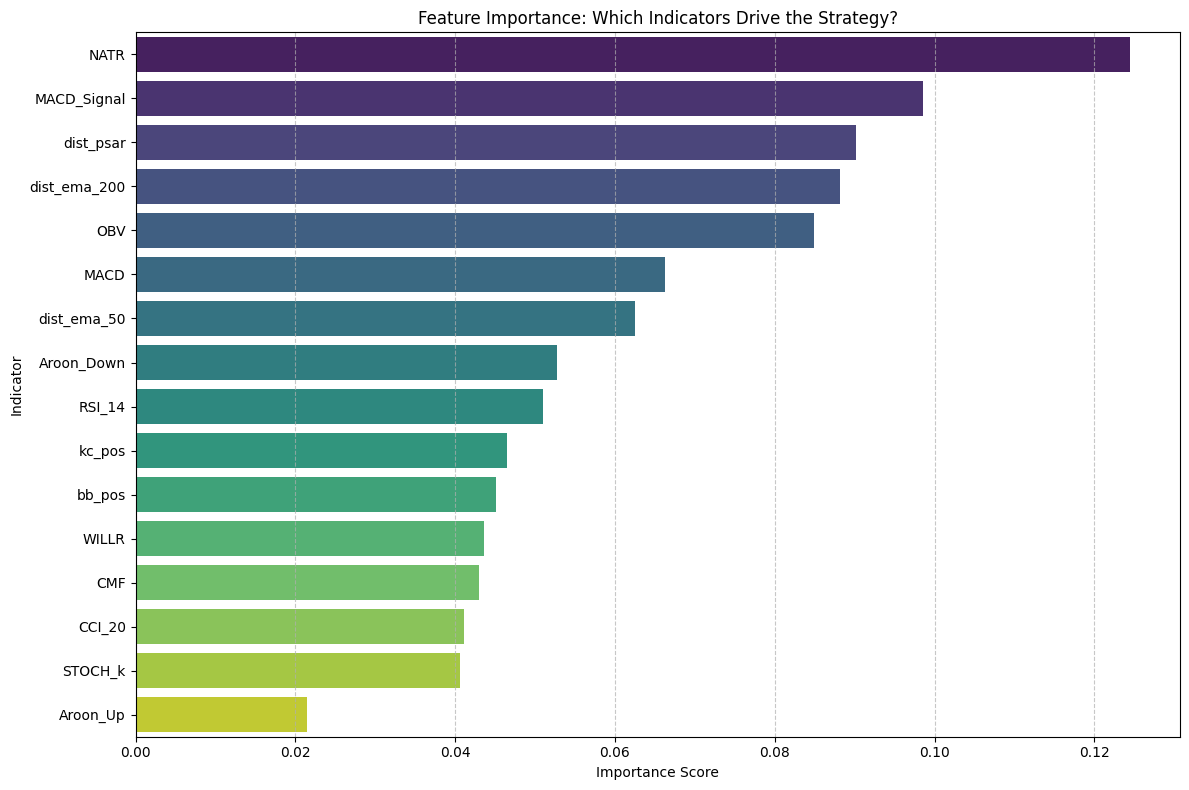


--- Top 5 Most Influential Features ---
         Feature  Importance
15          NATR    0.124500
4    MACD_Signal    0.098516
12     dist_psar    0.090155
11  dist_ema_200    0.088211
8            OBV    0.084859
3           MACD    0.066214
10   dist_ema_50    0.062488
1     Aroon_Down    0.052737
2         RSI_14    0.051013
13        kc_pos    0.046452
14        bb_pos    0.045138
7          WILLR    0.043580
9            CMF    0.043042
6         CCI_20    0.041126
5        STOCH_k    0.040568
0       Aroon_Up    0.021400


In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Extract Importance
importances = rf_model.feature_importances_
feature_names = X.columns
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# 2. Sort by Importance
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

# 3. Plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')

plt.title('Feature Importance: Which Indicators Drive the Strategy?')
plt.xlabel('Importance Score')
plt.ylabel('Indicator')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 4. Print Top 5
print("\n--- Top 5 Most Influential Features ---")
print(feat_imp_df)

In [ ]:
# 1. Trend Indicators (Baselines)
# These indicators identify the general direction of the market and help traders "follow the trend". 
# Simple Moving Average (SMA): The average price over a set number of periods.
# Exponential Moving Average (EMA): Similar to SMA but weights recent prices more heavily.
# Weighted Moving Average (WMA): Assigns heavier weight to the most recent data points.
# Hull Moving Average (HMA): Designed to reduce lag and improve smoothness.
# Kaufman Adaptive Moving Average (KAMA): Adjusts its sensitivity based on market noise.
# Ichimoku Cloud (Kinko Hyo): A comprehensive system showing trend, support, and resistance.
# Parabolic SAR (Stop and Reverse): Uses dots to indicate potential trend reversals.
# Average Directional Index (ADX): Measures the strength of a trend.
# Aroon Indicator: Identifies when a trend is starting or changing.
# Aroon Oscillator: Measures the difference between Aroon Up and Aroon Down.
# Linear Regression Trendline: A straight line that best fits a set of price data.
# Double Exponential Moving Average (DEMA): Further reduces lag from standard EMAs.
# Triple Exponential Moving Average (TEMA): Uses triple smoothing to minimize lag.
# Supertrend: A trend-following indicator based on ATR.
# ZigZag: Filters out smaller price movements to show significant trends.
# Schaff Trend Cycle (STC): Combines MACD with a stochastic for faster trend signals.
# TRIX: A triple-smoothed exponential oscillator for trend identification.
# Detrended Price Oscillator (DPO): Removes trend to highlight short-term cycles.
# Alligator (Bill Williams): Uses three smoothed moving averages to identify trends.
# Gann Fans/Gann Lines: Based on geometric angles of price and time. 

# 2. Momentum Indicators (Oscillators)
# These measure the speed of price movements and identify overbought or oversold conditions.
# 21. Relative Strength Index (RSI): Ranges 0-100; signals overbought (>70) or oversold (<30).
# 22. Stochastic Oscillator: Compares closing price to its range over time.
# 23. MACD (Moving Average Convergence Divergence): Shows the relationship between two EMAs.
# 24. Commodity Channel Index (CCI): Identifies cyclical trends and reversals.
# 25. Williams %R: Shows where the current price is relative to the highest high.
# 26. Awesome Oscillator (AO): Measures market momentum using 34 and 5-period SMAs.
# 27. Momentum Indicator: Measures the rate of change of prices.
# 28. Rate of Change (ROC): Calculates the percentage change in price between periods.
# 29. Money Flow Index (MFI): Volume-weighted version of RSI.
# 30. Relative Vigor Index (RVI): Measures the strength of a trend by comparing closing prices.
# 31. Stochastic RSI: A stochastic applied to RSI values for increased sensitivity.
# 32. Ultimate Oscillator: Uses three different timeframes to reduce false signals.
# 33. Chande Momentum Oscillator (CMO): Calculates momentum based on unsmoothed data.
# 34. Gator Oscillator: Derived from the Alligator indicator to show trend changes.
# 35. DeMarker (DeM): Compares most recent maximum and minimum prices.
# 36. True Strength Index (TSI): A double-smoothed momentum oscillator.
# 37. Vortex Indicator: Two lines (+VI and -VI) that identify the start of a new trend.
# 38. Fisher Transform: Transforms prices into a Gaussian normal distribution.
# 39. Center of Gravity Oscillator: Identifies major turning points without lag.
# 40. Percentage Price Oscillator (PPO): Similar to MACD but shown in percentages. 

# 3. Volatility Indicators
# These measure how far price stretches from its mean, helping with risk management and breakout detection.
# 41. Bollinger Bands: A moving average with two standard deviation bands.
# 42. Average True Range (ATR): Measures the average range of price movement.
# 43. Standard Deviation: Measures how spread out price data is from the mean.
# 44. Keltner Channels: Volatility-based envelopes set above/below an EMA.
# 45. Donchian Channels: Shows the highest high and lowest low over a period.
# 46. Envelopes: Two moving averages set at a fixed percentage above and below price.
# 47. Chaikin Volatility: Measures the difference between high and low prices.
# 48. Bollinger Bandwidth: Measures the distance between upper and lower Bollinger Bands.
# 49. STARC Bands: Combines moving averages and ATR to create volatility channels.
# 50. Ulcer Index: Measures "stress" by analyzing the depth and duration of price drops.
# 51. Relative Volatility Index (RVI): Measures the direction of volatility.
# 52. Choppiness Index: Determines if the market is trending or "choppy".
# 53. Mass Index: Predicts reversals by measuring the narrowing/widening of price ranges.
# 54. Historical Volatility (HV): Measures the past standard deviation of an asset. 
    
#     4. Volume & Support/Resistance Indicators
# These measure market participation and key price levels.
# 55. On-Balance Volume (OBV): Relates volume to price change to confirm trends.
# 56. Accumulation/Distribution (A/D): Measures the cumulative flow of money.
# 57. Chaikin Money Flow (CMF): Measures the amount of Money Flow Volume over a period.
# 58. Volume Weighted Average Price (VWAP): Average price weighted by total volume.
# 59. Pivot Points (Standard): Key levels calculated from the previous day's H/L/C.
# 60. Fibonacci Retracements: Horizontal lines based on Fibonacci ratios to find support.
# 61. Volume Profile: Shows volume traded at specific price levels.
# 62. Ease of Movement (EOM): Relates price change to volume.
# 63. Money Flow Ratio: Compares positive and negative money flow.
# 64. Negative Volume Index (NVI): Focuses on days where volume decreased.
# 65. Positive Volume Index (PVI): Focuses on days where volume increased.
# 66. Price Volume Trend (PVT): Cumulative volume that adds a percentage of the day's volume.
# 67. Trade Volume Index (TVI): Used to determine whether an asset is being accumulated.
# 68. Market Profile: Visualizes price and volume over time (TPO).
# 69. Balance of Power (BOP): Measures the strength of buyers vs. sellers.
# 70. Camarilla Pivot Points: A variation of pivots providing tighter support/resistance.
# 71. Woodie’s Pivot Points: Weighted differently to emphasize recent price action.
# 72. Fibonacci Extensions: Projects potential future profit-taking levels.
# 73. Elder Force Index: Combines price movement and volume to measure trend power.
# 74. Vortex Indicator (VI): Identifies the start of a trend based on high/low distance.
# 75. Chaikin Oscillator: Applies MACD to the Accumulation/Distribution line.
# 76. Force Index: Uses price, volume, and time to identify trend strength.
# 77. Klinger Oscillator: Compares volume flowing through an asset with price

# 5. Specialized & Hybrid Indicators
# Fractals (Bill Williams): Arrows that highlight local high and low points.
# Heiken Ashi: Specialized candlesticks that filter market noise.
# TD Sequential: Identifies trend exhaustion and potential price flips.
# Murrey Math Lines: Support/resistance levels based on Gann's theory.
# Psychological Line: Measures the ratio of rising days to total days.
# Volume Rate of Change (VROC): Percentage change in volume.
# Typical Price: (High + Low + Close) / 3.
# Median Price: (High + Low) / 2.
# Adaptive Lagging Line: Follows price but smooths out data without excessive lag.
# Trend Intensity Index (TII): Measures the strength of a trend.
# Rainbow Moving Average: Multiple MAs used together to show trend maturity.
# Linear Regression Slope: Measures the rate of change of a linear regression line.
# CVI (Chart Volatility Index): A custom measure of intraday volatility.
# Gpivot Ressup: Dynamic support and resistance pivot variation.
# DMI (Directional Movement Index): Consists of +DI and -DI lines.
# TMA (Triangular Moving Average): Double-smoothed version of the SMA.
# QQE (Quantitative Qualitative Estimation): Smother RSI-based indicator.
# RSX (Relative Strength Index smoothed): A noise-free version of RSI.
# ATR Trailing Stop: A stop-loss level that moves with the price.
# Connors RSI: Combines RSI, Up/Down Length, and Rate of Change.
# Forex Sentiment: Measures the percentage of long vs. short retail positions.
# Currency Strength Meter: Compares one currency's performance against all others.
# Market Sessions Indicator: Highlights Asian, London, and New York trading hours. 



